# SYSTEM FLOW OVERVIEW (HIGH-LEVEL)

1. **Sensor Model Setup**
   - Define where and how sensors collect data.
   - Example: `FixedSensorModel` defines sensor locations and observation regions.

2. **Wind Model**
   - Defines how wind transports particles.
   - Example: `RealWind` model uses NASA MERRA-2 wind fields.

3. **Kernel Selection**
   - Defines basis functions used to approximate the source distribution.
   - Example: EQ (RBF-like) or GaussianBases kernels.

4. **Model Initialization**
   - Create the `MeshFreeAdjointAdvectionDiffusionModel` (mInfer).
   - Pass: boundary, resolution, kernel, sensor model, wind model, diffusion constant `k_0`, etc.

5. **Particle Simulation**
   - Generate particles:
     - Either based on `sensor locations` (lecturer's default) or
     - Custom `grid-based particles` (your modification with polygons)
   - Particles are used to approximate the adjoint solution (i.e., backward in time diffusion and advection).

6. **Regressor Matrix Computation (computeModelRegressors)**
   - Diffuse particles backward in time.
   - Use wind + diffusion.
   - Evaluate basis functions at particle positions (via `kernel.getPhiValues`).
   - Outputs matrix `X` used in source inference.

7. **Source Inference**
   - Solve the inverse problem to infer the likely pollution source.
   - Compute `Z` distribution (mean, covariance).

8. **Forward Concentration Simulation (computeConcentration)**
   - Use `Z` samples.
   - Forward diffusion of particles (forward-time pass).
   - Compute concentration at each grid/particle.

---

### **RELATIONSHIPS**

- **SensorModel** → Defines where to evaluate adjoints (H matrix)
- **WindModel** → Moves particles in both `computeModelRegressors()` and `computeConcentration()`
- **Kernel** → Computes basis functions (Phi values) at particle positions
- **Model** → Coordinates everything

---

Would you like me to also help draw a simple flowchart (blocks/arrows)?


### Flow:
1. **Model Initialization**
   - You define the resolution, boundary, diffusion coefficient (k₀), kernel, and wind model.
   
2. **Kernel Feature Generation**
   - EQ or GaussianBases kernels generate basis functions (Φ) based on random features or grid-based features depending on the kernel type.

3. **Sensor Setup**
   - FixedSensorModel defines where sensors (observation points) are located in space and time.
   
4. **Particle Generation**
   - Particles are initialized near sensors (sensor-based approach) or in grid cells (your polygon/grid approach).

5. **Adjoint Simulation (Backward in Time)**
   - Particles are diffused backward in time, influenced by wind (windmodel.getwind).

6. **Basis Evaluation**
   - Kernel Φ values are computed at particle positions at each timestep.

7. **Compute X Matrix**
   - The weighted sum of Φ values over particles gives the regressor matrix X.

8. **Source Inference**
   - From X and observations, infer the source distribution (Z) via statistical methods.

9. **Forward Concentration Prediction**
   - With inferred Z, particles are diffused forward in time to compute predicted concentrations.

10. **Visualization/Output**
    - Display concentration maps, source locations, and uncertainty estimates.


In [3]:
#from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel, RemoteSensingModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
from pyproj import Proj
from scipy.spatial import cKDTree
from netCDF4 import Dataset
from datetime import datetime, timedelta

class RealWind:
    def __init__(self, start_date="2019-10-01", num_days=9):
        """
        Precompute and store wind data in a pandas DataFrame for fast lookup.
        The table includes time (in minutes), northing, easting, U (east wind), and V (north wind).
        """
        self.proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
        self.wind_table = []  # List to accumulate wind data

        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        layer_range = (56, 68)  # Height range for averaging wind speeds
        bounding_box = (140.5, -39, 150, -34)

        for day_offset in range(num_days):
            current_date = start_date + timedelta(days=day_offset)
            date_str = current_date.strftime('%Y%m%d')
            file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.{date_str}.nc4"

            try:
                dataset = Dataset(file_path, 'r')
                lats = dataset.variables['lat'][:]
                lons = dataset.variables['lon'][:]
                
                # Apply the bounding box filter
                lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
                lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]

                lats = lats[lat_indices]
                lons = lons[lon_indices]

                # Load and filter wind data within the bounding box
                eastward_wind = dataset.variables['U'][:, :, lat_indices, :][:, :, :, lon_indices]
                northward_wind = dataset.variables['V'][:, :, lat_indices, :][:, :, :, lon_indices]

                # Average over the specified vertical layers
                layer_range_slice = slice(layer_range[0], layer_range[1])
                eastward_wind_avg = np.mean(eastward_wind[:, layer_range_slice, :, :], axis=1)
                northward_wind_avg = np.mean(northward_wind[:, layer_range_slice, :, :], axis=1)

                # Read and store time directly in minutes
                print("NASA Time Units:", dataset.variables['time'].units)
                time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!

                for t_idx, t_val in enumerate(time_var):
                    if not np.isfinite(t_val):
                        continue  # Skip invalid time values
                    timestamp = t_val  # Store time directly in minutes

                    # Vectorized coordinate transformation
                    lon_grid, lat_grid = np.meshgrid(lons, lats)
                    easting, northing = self.proj(lon_grid, lat_grid)

                    # Flatten arrays to create a table of points
                    easting = easting.flatten()
                    northing = northing.flatten()
                    u_wind = eastward_wind_avg[t_idx].flatten()
                    v_wind = northward_wind_avg[t_idx].flatten()

                    # Filter out invalid projections
                    valid_mask = np.isfinite(easting) & np.isfinite(northing) & np.isfinite(u_wind) & np.isfinite(v_wind)

                    # Append valid data to the wind table
                    self.wind_table.extend(
                        zip([timestamp] * np.sum(valid_mask),
                            northing[valid_mask],
                            easting[valid_mask],
                            u_wind[valid_mask],
                            v_wind[valid_mask])
                    )

                dataset.close()

            except FileNotFoundError:
                print(f"File for {date_str} not found.")
            except Exception as e:
                print(f"Error loading {date_str}: {e}")

        # Convert to pandas DataFrame for fast lookups
        self.wind_table = pd.DataFrame(self.wind_table, columns=["Timestamp", "Northing", "Easting", "East Wind", "North Wind"])

        # Clean data: Drop NaN or Inf values
        self.wind_table = self.wind_table.replace([np.inf, -np.inf], np.nan)
        self.wind_table = self.wind_table.dropna()

        # Sort by timestamp for faster temporal queries
        self.wind_table = self.wind_table.sort_values(by="Timestamp").reset_index(drop=True)

        # Build a spatial KD-Tree for efficient spatial querying
        self.wind_tree = cKDTree(self.wind_table[["Easting", "Northing"]].values)

        print(f"Wind data precomputed for {len(self.wind_table)} points across {num_days} days.")
    
    def getwind(self, coords):
        """
        Get the nearest-neighbor wind speed for particles at given positions and times.

        Parameters:
        - coords: A tensor of shape (num_particles, num_observations, 3)
                  where each entry is [time, easting, northing].

        Returns:
        - wind_data: A tensor of shape (num_particles, num_observations, 2)
                     where each entry is [east_wind_speed, north_wind_speed].
        """
        num_particles, num_observations, _ = coords.shape
        wind_data = np.full((num_particles, num_observations, 2), np.nan)  # Initialize with NaN

        timestamps = coords[:, :, 0].flatten()  # Keep time in minutes

        for i in range(num_particles):
            for j in range(num_observations):
                easting, northing = coords[i, j, 1], coords[i, j, 2]
                timestamp = timestamps[i * num_observations + j]

                closest_time_idx = (np.abs(self.wind_table["Timestamp"] - timestamp)).idxmin()
                dist, closest_idx = self.wind_tree.query([easting, northing], k=1)

                wind_data[i, j] = self.wind_table.loc[closest_idx, ["East Wind", "North Wind"]]

        return wind_data


In [5]:
windmodel = RealWind(start_date="2019-12-15", num_days=5)  # Load real wind data


NASA Time Units: minutes since 2019-12-15 01:30:00


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\706863214.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\706863214.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


NASA Time Units: minutes since 2019-12-16 01:30:00
NASA Time Units: minutes since 2019-12-17 01:30:00
NASA Time Units: minutes since 2019-12-18 01:30:00
NASA Time Units: minutes since 2019-12-19 01:30:00
Wind data precomputed for 7040 points across 5 days.


Generate some synthetic concentration data.
We have a source of pollution at [10, 20] at time -4.

In [6]:
from scipy.stats import norm

def getrealconc(t,x,y,D):
    """For a sythentic dataset, provides the real concentration that will result from the simulated sources
    """
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+4))
    if blobsize<1: blobsize=1
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 1000*norm(0,blobsize).pdf(d)*norm(10,1).cdf(t)/blobsize #normalised.
    
    return [t,t+10,x,y],v

In [7]:
X = []
Y = []
D = 2
for x in np.linspace(10,90,7):#7):
    for y in np.linspace(10,90,7):#7):
        for t in np.linspace(0,60,7):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

Plot the concentration over time:

C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


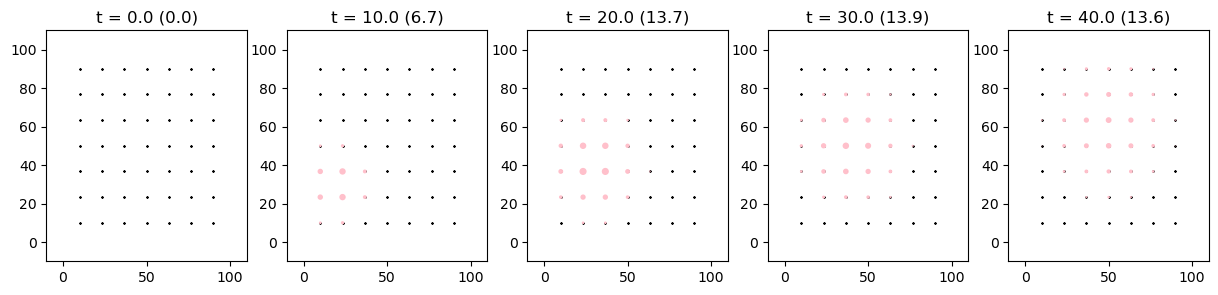

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=[15,3])
for i,t in enumerate(np.arange(0,50,10)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')
    plt.title("t = %0.1f (%0.1f)" % (t,np.sum(Y[keep])))
    

In [9]:
from advectionGPdatasets import proposeboundary
boundary = proposeboundary(X) #for our given observation locations pick a boundary that fits them all
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10
#boundary = ([-7.0, -10, -10], [77.0, 100, 100])
print(boundary)

([-7.0, -10, -10], [77.0, 98.0, 98.0])


In [10]:
np.random.seed(42) #random seed fixed at start
#set up our model...
N_feat = 1500 #Number of features used to infer the source
k = EQ(10, 1) #our choice of kernel [EQ kernel, using fourier features]
#k = GaussianBases(25, 1) #<--- This kernel doesn't place features randomly, but on a grid!
res = [120,30,30] #120 time steps...

noiseSD = 0.001 #this is how noisy the measurements are.

sensors = FixedSensorModel(X,3) #this is how our data is observed.

# windmodel=WindSimple(1,1) #wind is the same everywhere it heads north east at 1.4m/s
windmodel = RealWind(start_date="2019-10-01", num_days=2)  # Load real wind data

k_0 = 0.5 #diffusion cooef? [doesn't match the simulation!!]

#Initiate new model for inference
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0)

mInfer.computeModelRegressors(Nparticles=20) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

#simple way
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

#if we want lots of samples from the posterior do this...
Nsamps = 20
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

NASA Time Units: minutes since 2019-10-01 01:30:00


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\706863214.py:49: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\706863214.py:49: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)  # Already in minutes!


NASA Time Units: minutes since 2019-10-02 01:30:00
Wind data precomputed for 2816 points across 2 days.
Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\2387169945.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


In [14]:
print(type(mInfer.windmodel))  # This should print <class '__main__.RealWind'>
wind_data = self.windmodelgetwind(coords)

# Print shape before passing to getwind
print("Shape of coords being passed to getwind:", particles[:,:,1:].shape)  
print("Expected shape: (num_particles, num_observations, 3) [time, easting, northing]")
mInfer.computeModelRegressors(Nparticles=20) 

# Call windmodel.getwind
wind = self.windmodel.getwind(particles[:,:,1:])*dt




<class '__main__.RealWind'>


NameError: name 'self' is not defined

In [11]:
sourcemean.shape

(120, 30, 30)

In [12]:
mInfer.getGridCoord([10,0,0])[0]

24

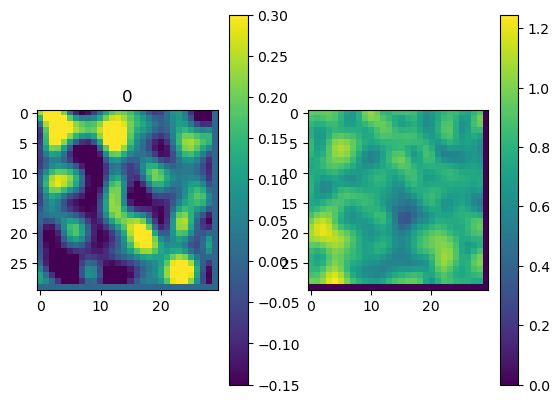

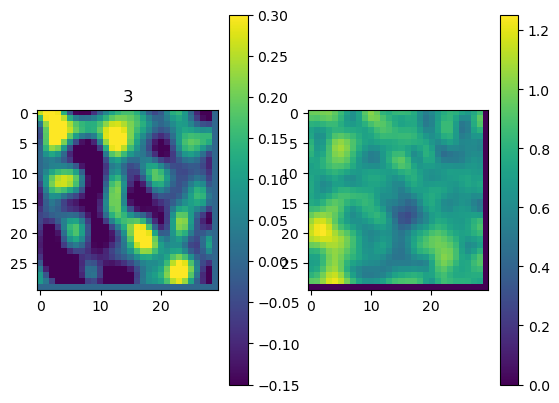

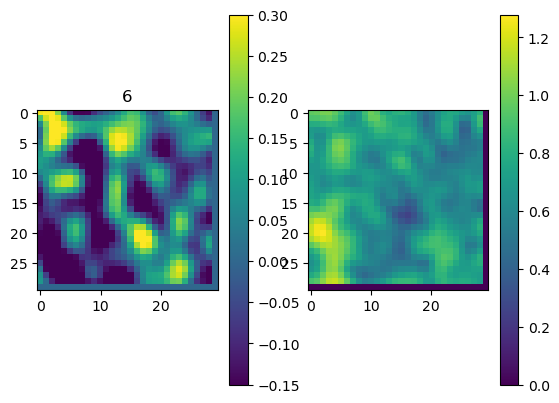

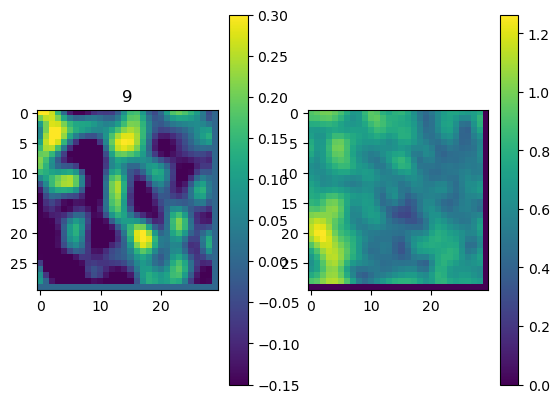

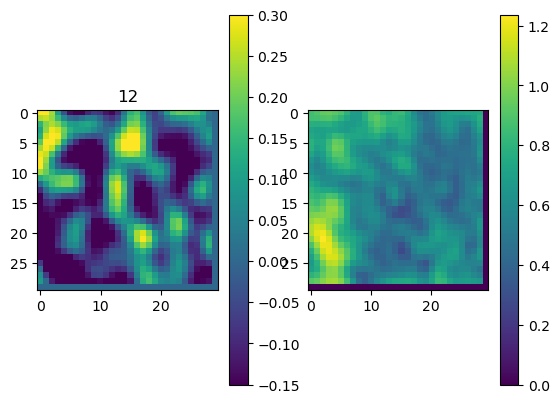

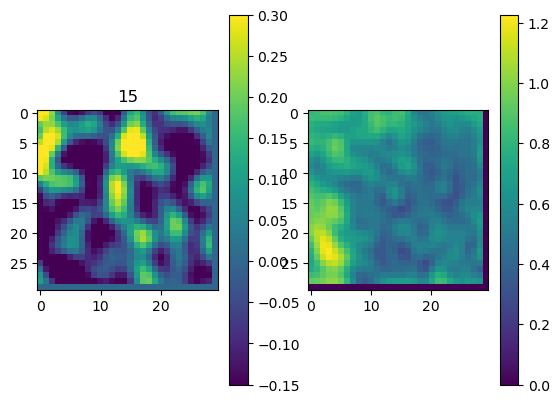

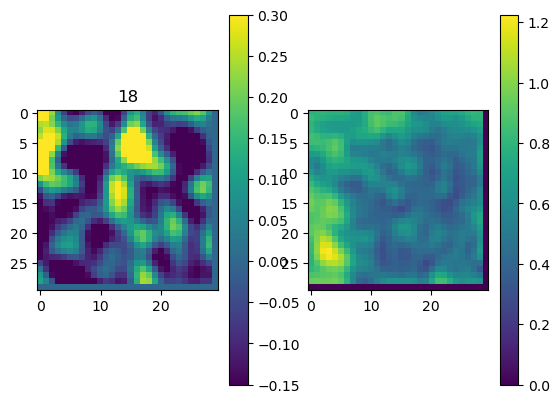

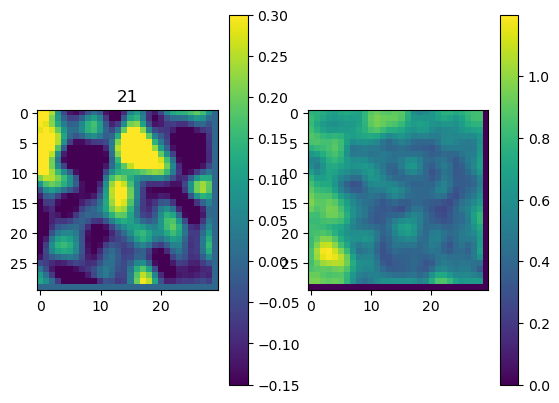

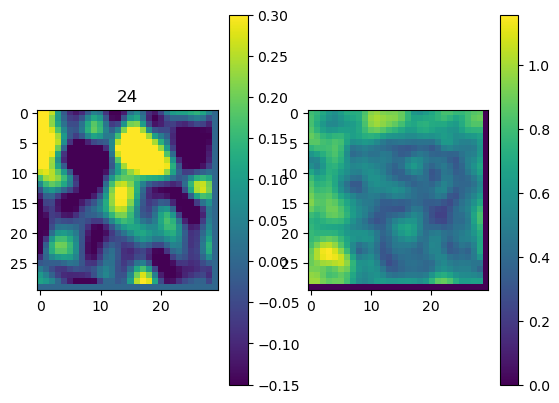

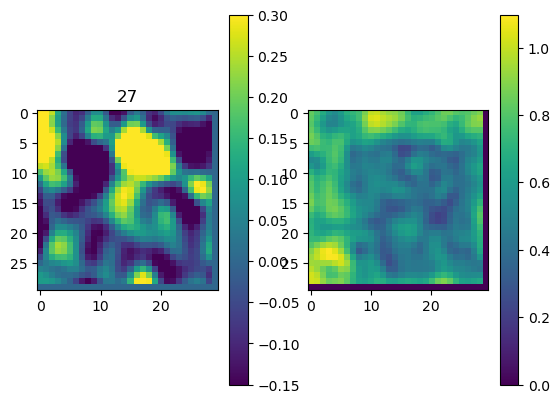

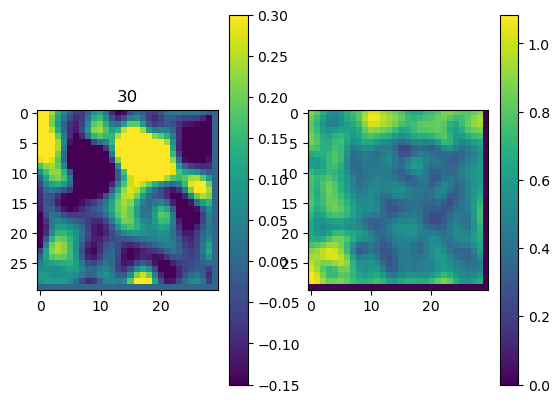

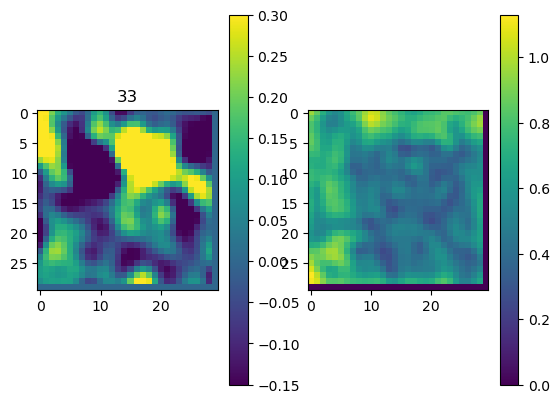

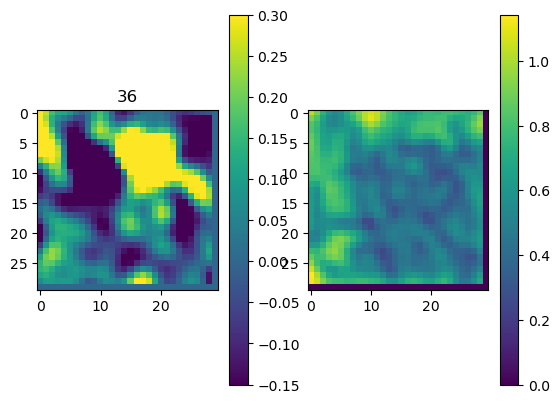

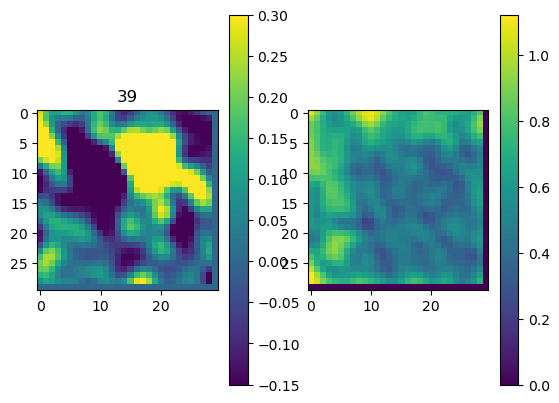

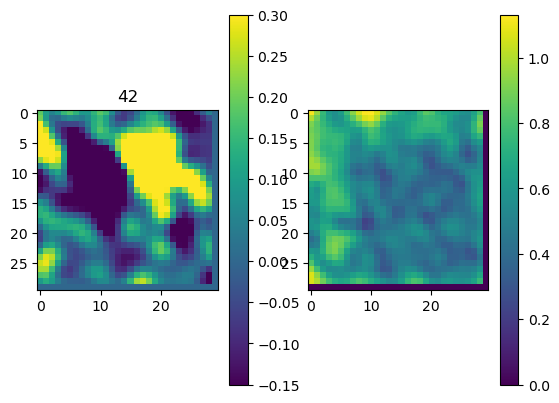

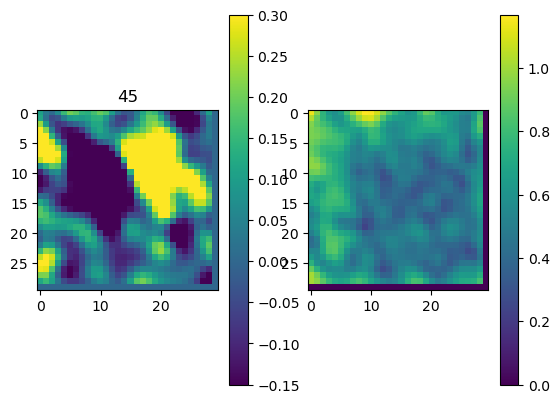

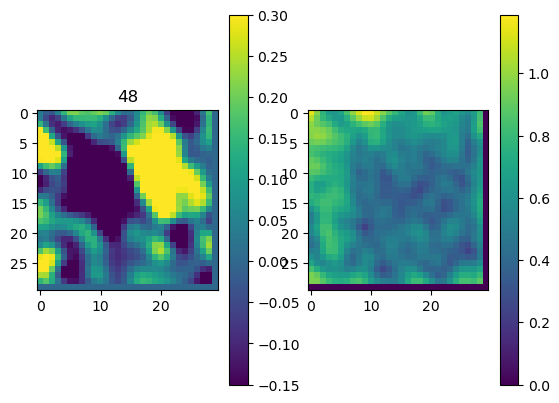

In [13]:
for t_index in range(0,50,3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(t_index)
    plt.imshow(sourcemean[t_index,:,:],clim=[-0.15,0.3])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(np.sqrt(sourcevar[t_index,:,:]))#,clim=[-0.15,0.3])
    plt.colorbar()

In [14]:
sensors = RemoteSensingModel()

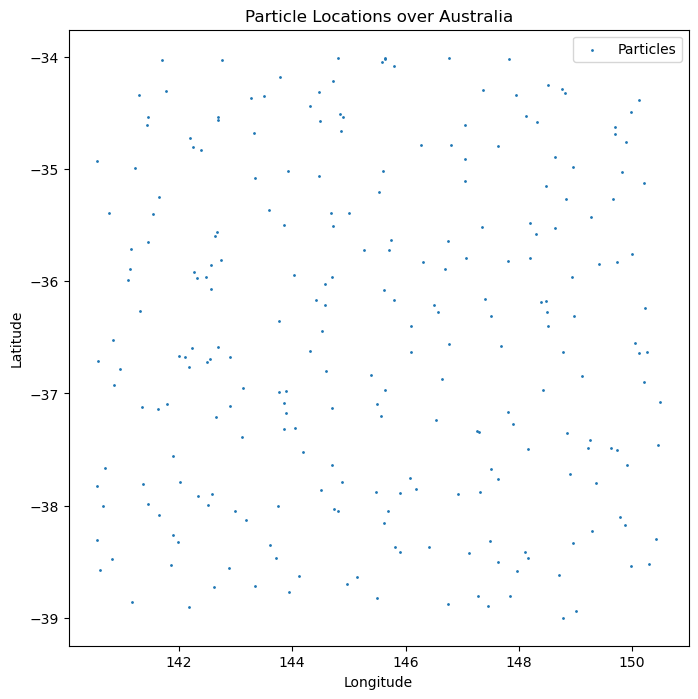

In [15]:
import matplotlib.pyplot as plt
from pyproj import Proj, transform

proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
proj_latlon = Proj(proj='latlong', datum='WGS84')
Nparticles=5
particles = sensors.genParticles(Nparticles)
# Example: Plot your particle cloud (Nparticles, Nobs, 3)
x = particles[...,1].flatten()
y = particles[...,2].flatten()
lon, lat = proj(x, y, inverse=True)

plt.figure(figsize=(8,8))
plt.scatter(lon, lat, s=1, label="Particles")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Particle Locations over Australia")
plt.legend()
plt.show()


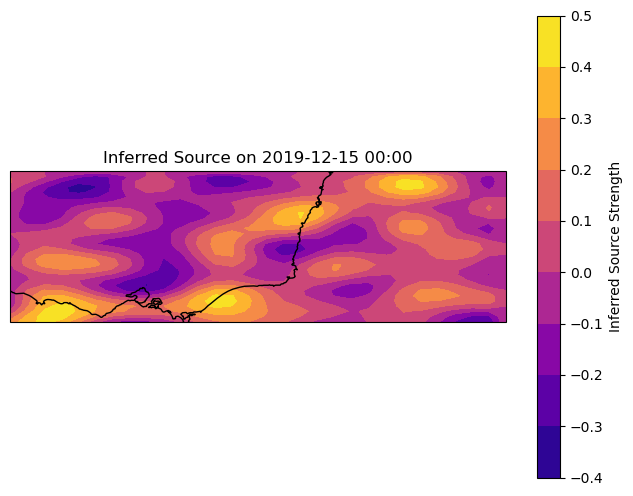

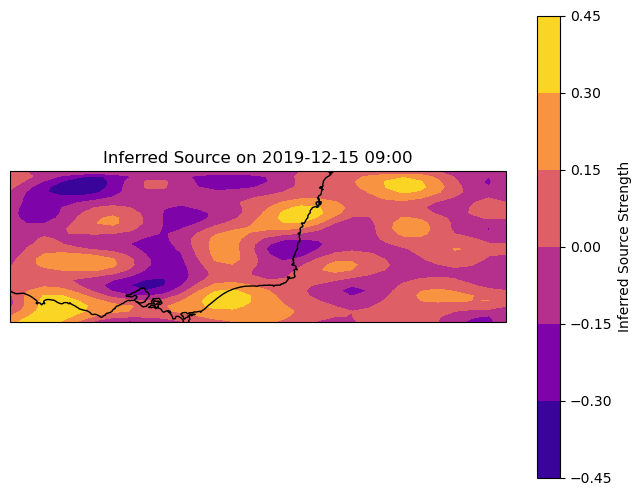

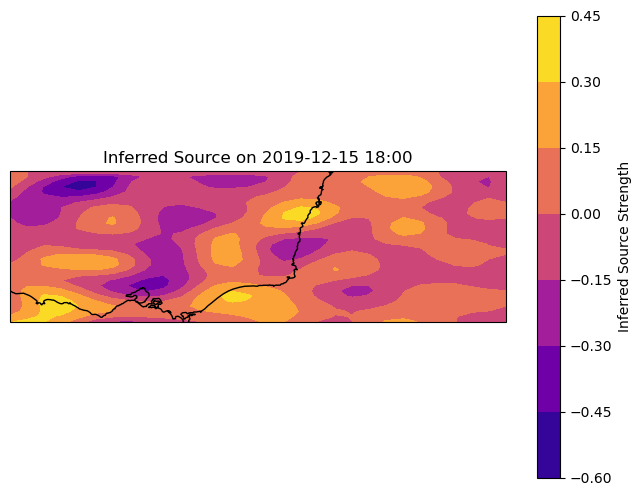

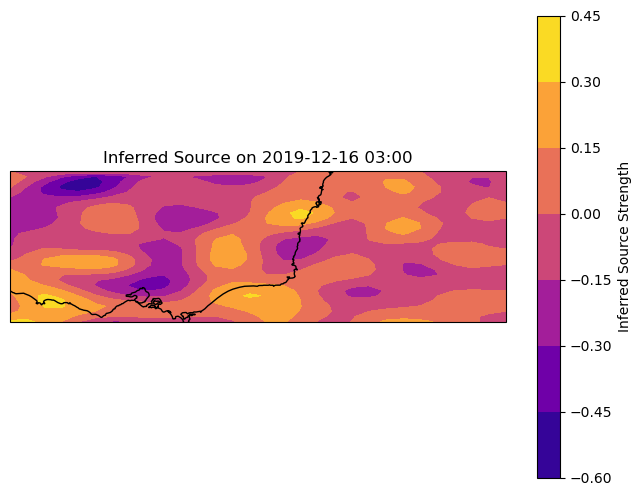

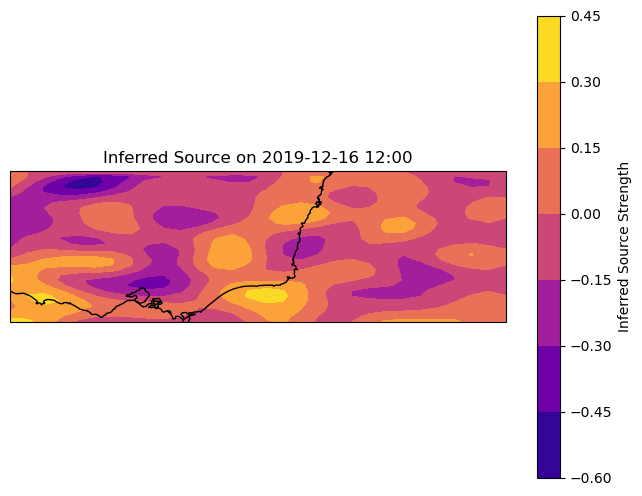

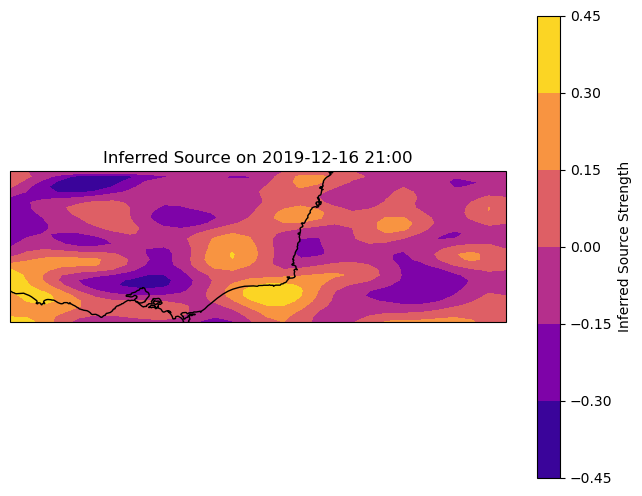

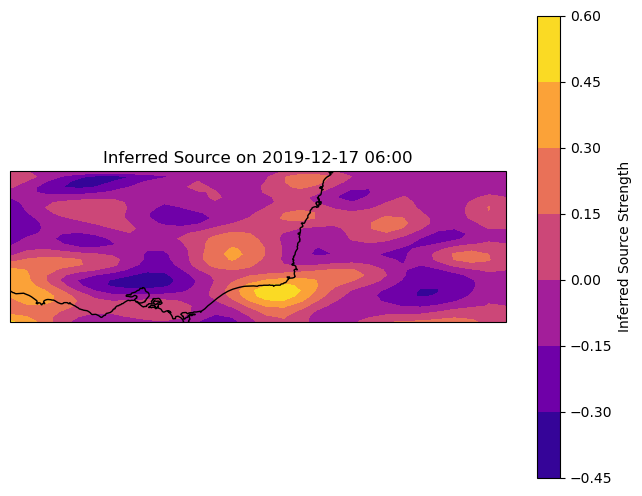

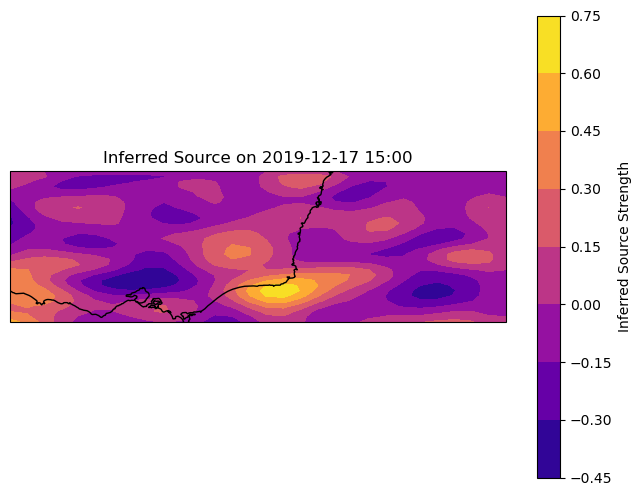

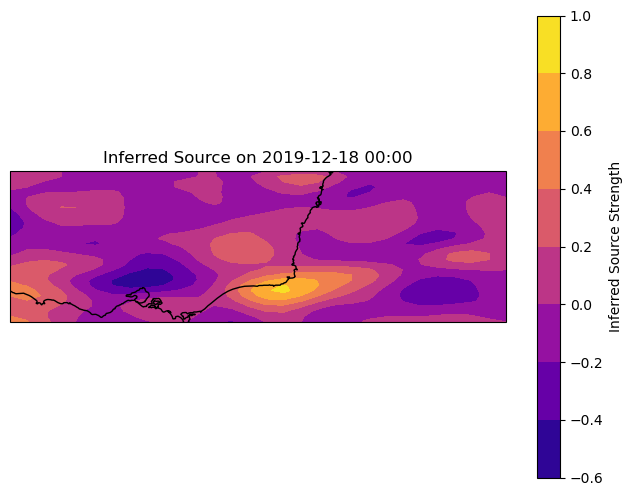

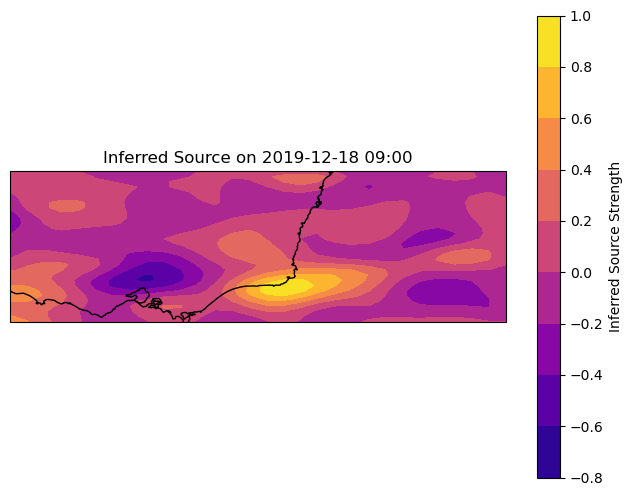

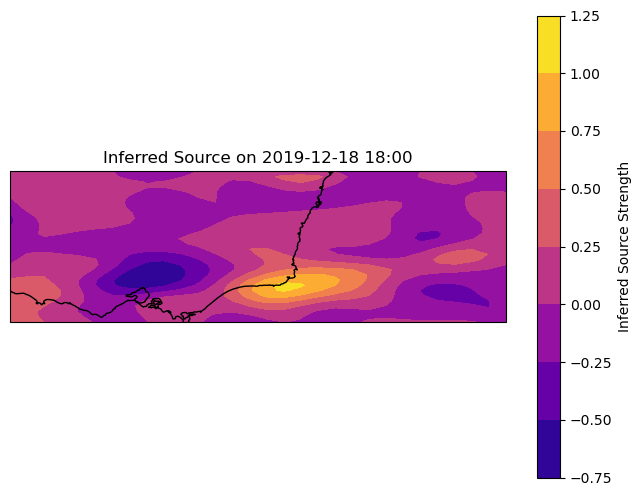

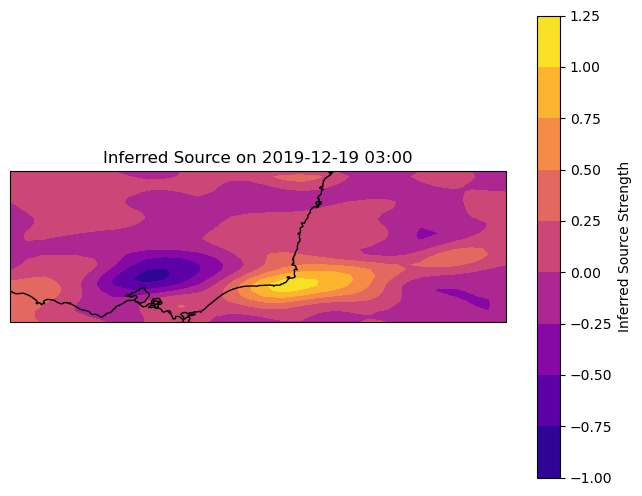

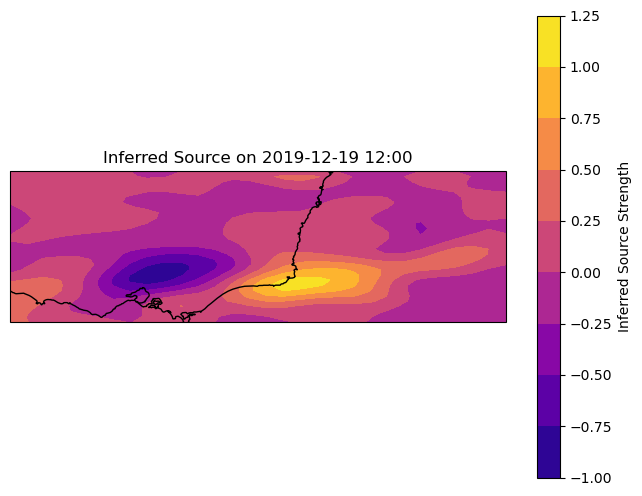

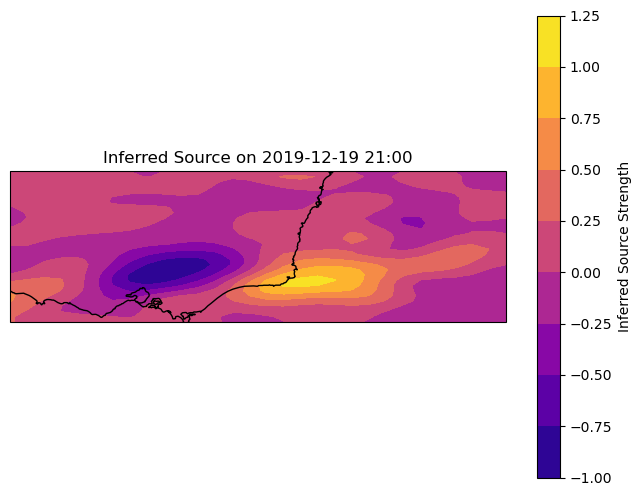

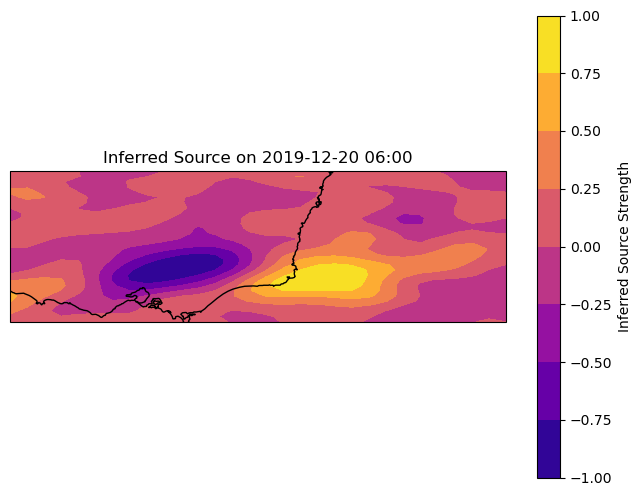

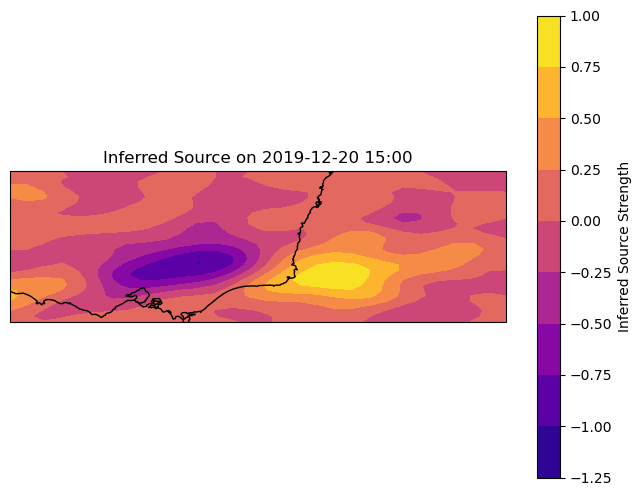

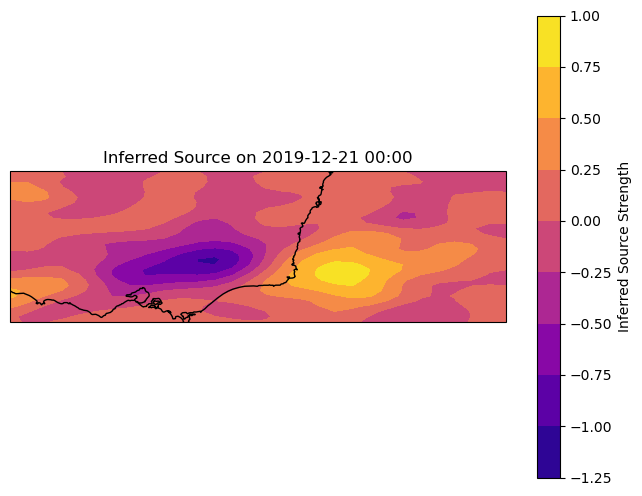

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import datetime

# Assuming sourcemean is your source array and you already defined lon_bins, lat_bins

start_date = datetime.datetime(2019, 12, 15, 0, 0)
time_interval = 3 * 60  # 3 hours in minutes
lon_bins = np.linspace(140.5, 157, sourcemean.shape[2])
lat_bins = np.linspace(-39, -34, sourcemean.shape[1])

for t_index in range(0, 50, 3):
    current_time = start_date + datetime.timedelta(minutes=t_index * time_interval)
    
    plt.figure(figsize=(8, 6))
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([140.5, 157, -39, -34])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # The actual heatmap
    cf = ax.contourf(lon_bins, lat_bins, sourcemean[t_index, :, :], transform=ccrs.PlateCarree(), cmap='plasma')
    plt.colorbar(cf, ax=ax, label='Inferred Source Strength')
    plt.title(f"Inferred Source on {current_time.strftime('%Y-%m-%d %H:%M')}")
    plt.show()


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


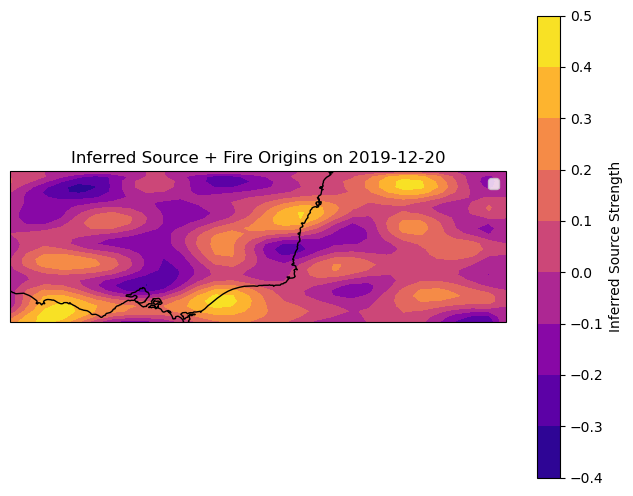

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


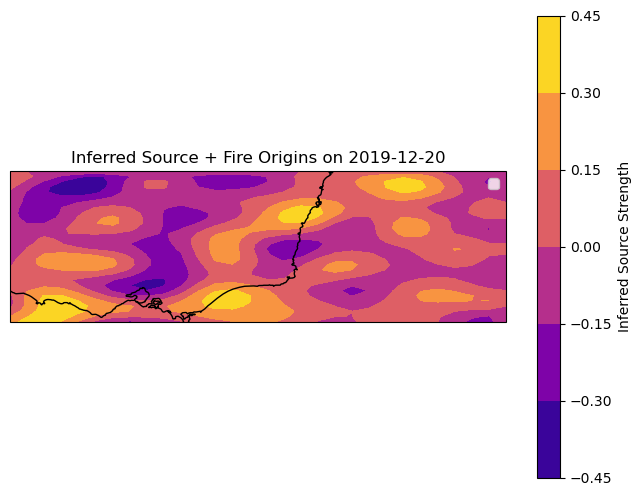

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


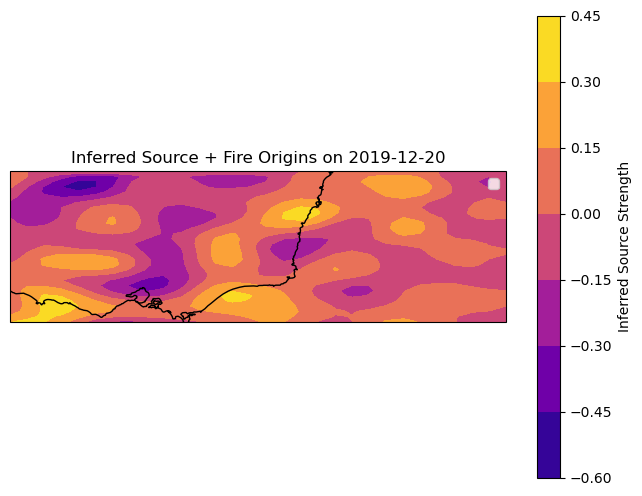

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


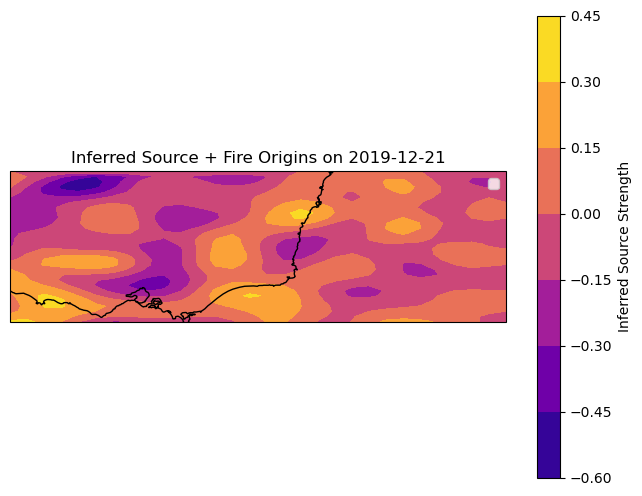

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


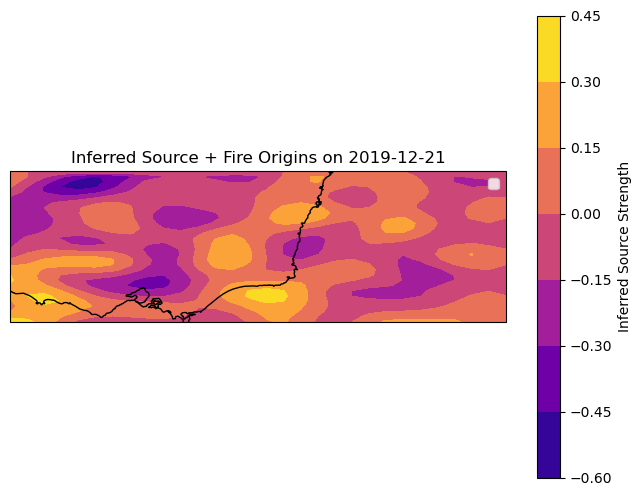

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


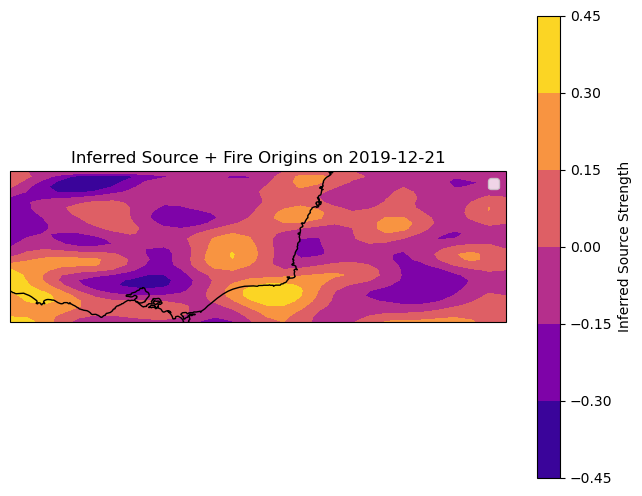

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


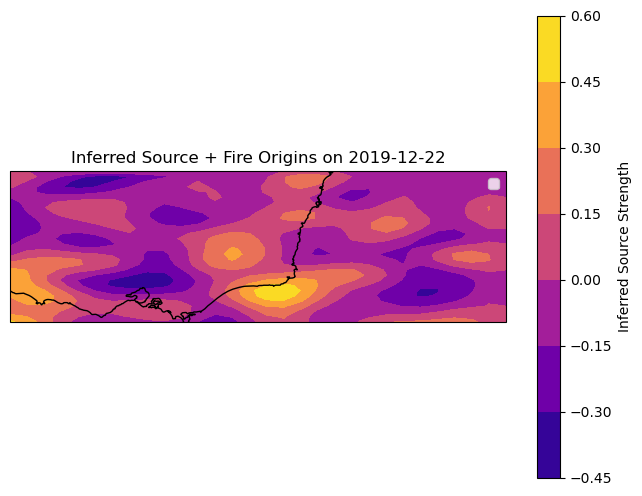

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


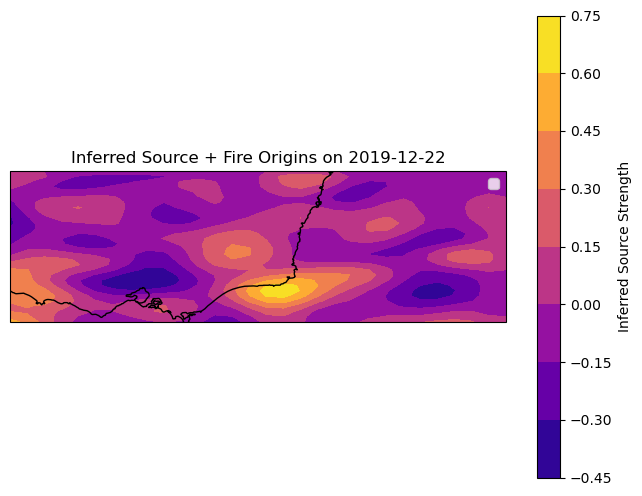

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


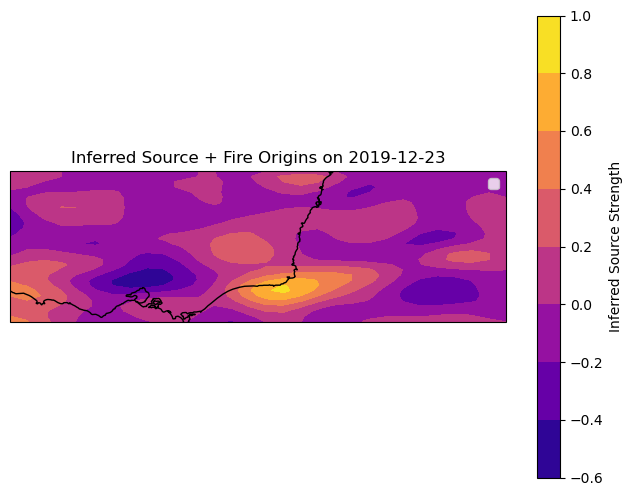

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


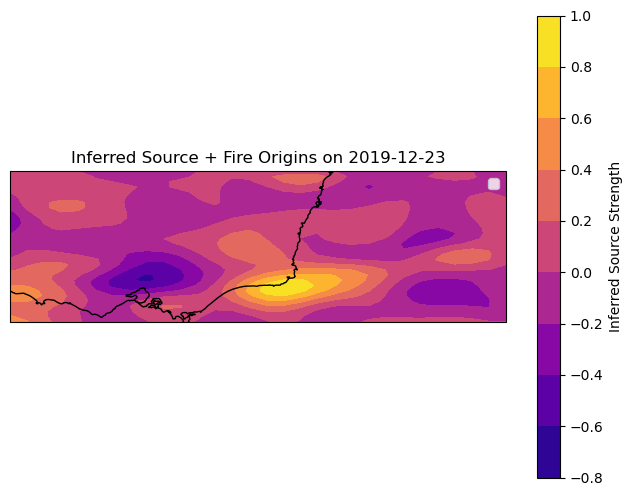

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


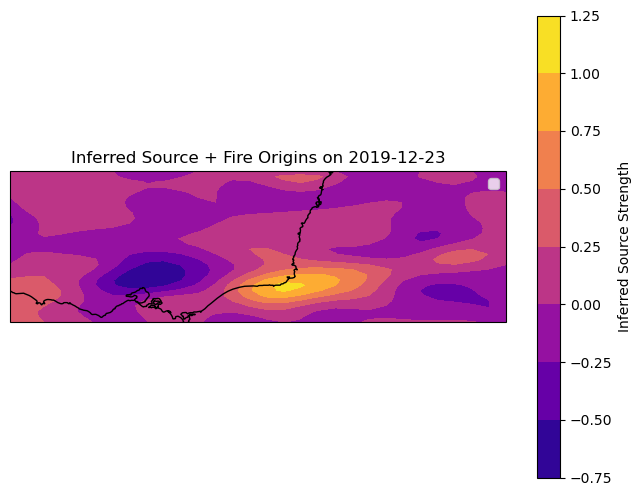

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


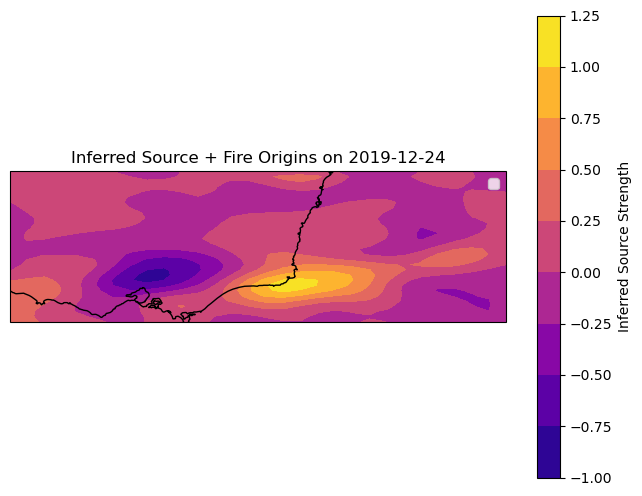

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


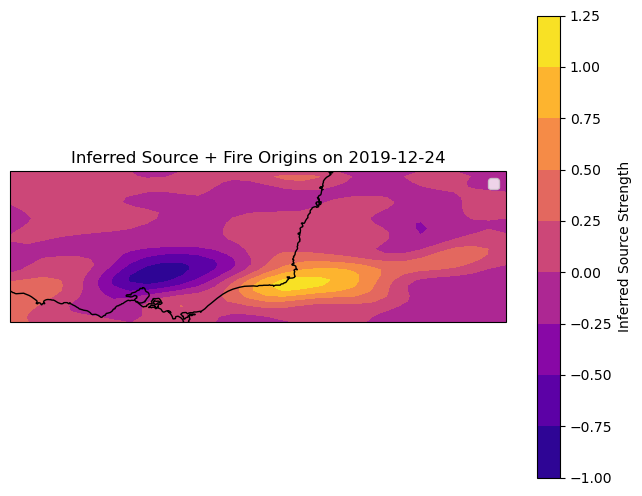

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


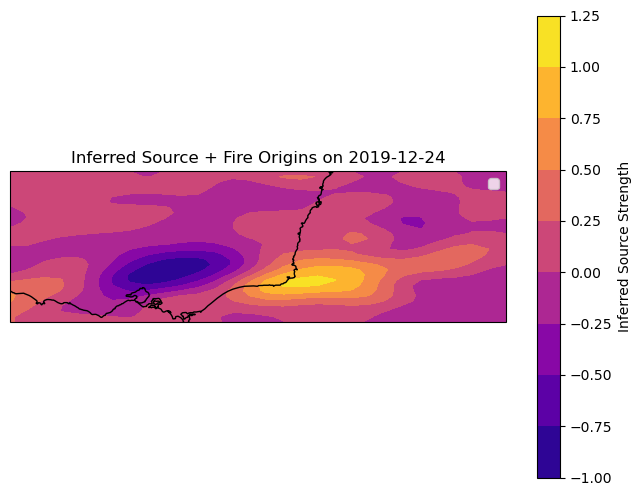

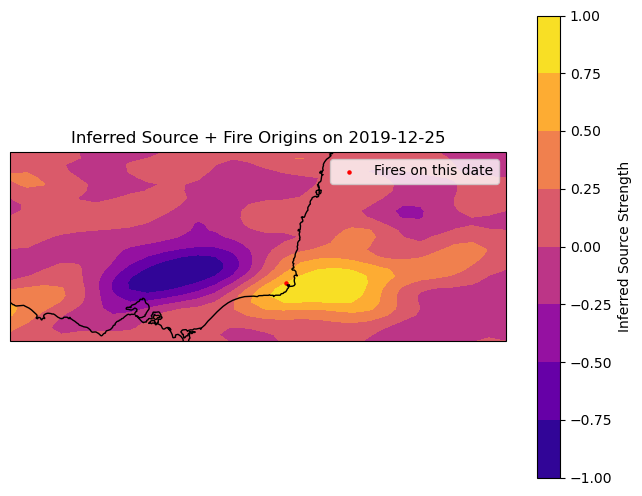

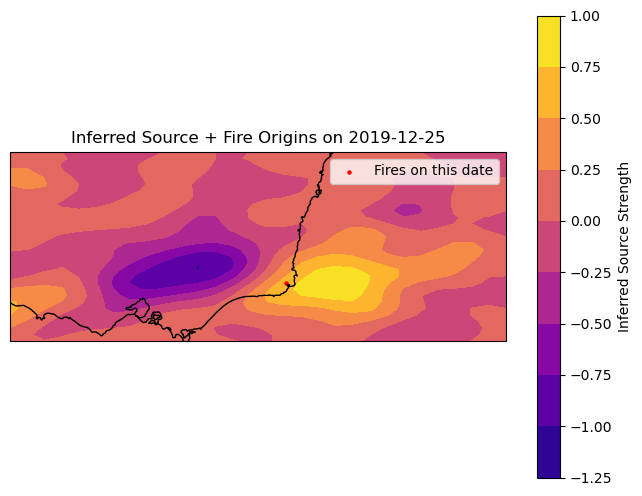

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_10492\1010983912.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


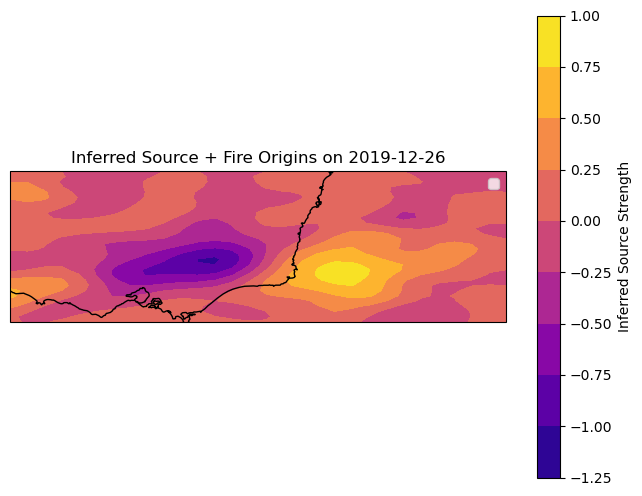

In [33]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import datetime

# ---- Load Fire Origins shapefile ----
shapefile_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Order_CD850U\mga94_54\esrishape\cma100\East Gippsland-0\FIRE\FIRE_HISTORY_ORIGIN.shp"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs(epsg=4326)  # convert to lat/lon
# Assuming your gdf has the full fire history data
fires_december = gdf[
    (gdf['FIRE_START'] >= '2019-12-15') & 
    (gdf['FIRE_START'] <= '2019-12-30')
]

start_date = datetime.datetime(2019, 12, 20, 0, 0)
time_interval = 3 * 60  # 3 hours in minutes
lon_bins = np.linspace(140.5, 157, sourcemean.shape[2])
lat_bins = np.linspace(-39, -34, sourcemean.shape[1])

# Loop over each time step and overlay with fires on the corresponding date
for t_index in range(0, 50, 3):
    current_time = start_date + datetime.timedelta(minutes=t_index * time_interval)
    current_date = current_time.date()
    
    # Filter fire origins for the matching date
    daily_fires = fires_december[fires_december['FIRE_START'].dt.date == current_date]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([140.5, 157, -39, -34])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Heatmap
    cf = ax.contourf(lon_bins, lat_bins, sourcemean[t_index, :, :], transform=ccrs.PlateCarree(), cmap='plasma')

    # Fire points for this date (if any)
    if not daily_fires.empty:
        daily_fires.plot(ax=ax, marker='o', color='red', markersize=5, label='Fires on this date')

    plt.colorbar(cf, ax=ax, label='Inferred Source Strength')
    plt.title(f"Inferred Source + Fire Origins on {current_time.strftime('%Y-%m-%d')}")
    plt.legend()
    plt.show()



In [ ]:
# Example: source is (Nt, Nx, Ny)
t_index = 21  # or any time step you are interested in
source_at_t = sourcemean[t_index, :, :]  # e.g., sourcemean from your plot

# Get the index of the maximum value
max_idx = np.unravel_index(np.argmax(source_at_t), source_at_t.shape)
x_idx, y_idx = max_idx

# Convert grid index back to real coordinates (e.g., using your grid definition)
real_x = x[x_idx] 
real_y = y[y_idx]

print(f"Max inferred source at: x = {real_x}, y = {real_y}")


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load your fire origins shapefile
gdf = gpd.read_file('path_to/FIREHISTORYORIGIN.shp')

# Load your inferred source heatmap data
# Assuming you already have these
# lat_bins, lon_bins = your grid lat/lon
# sourcemean = your inferred source (time steps x grid)

t_index = 21  # example time index

# Set up plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([141, 150, -39, -33])  # Zoom into Victoria

# Add base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot inferred source heatmap
cf = plt.contourf(lon_bins, lat_bins, sourcemean[t_index, :, :], 
                  transform=ccrs.PlateCarree(), cmap='plasma', alpha=0.7)
plt.colorbar(cf, label='Inferred Source Strength')

# Overlay fire origins points
gdf.plot(ax=ax, color='red', markersize=10, label='Historical Fire Origins', transform=ccrs.PlateCarree())

plt.legend()
plt.title("Inferred Source + Fire Origins (Victoria)")
plt.show()


# coding examples for generating particles

In [ ]:
exampleparticles = mInfer.genParticlesFromObservations(10)

In [ ]:
exampleparticles[:,0,2]

In [ ]:
plt.plot(exampleparticles[0,:,1],exampleparticles[0,:,2],'x')

In [ ]:
exampleparticles.shape #3430 points going in... each at a given time/space

In [ ]:
trickyparticles = np.random.rand(10,20,18,30,3)

In [ ]:
trickyparticles.shape

In [ ]:
mInfer.kernel.N_feat